In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import time
import numpy as np
import tensorflow as tf
from random import randint

from ntm import NTM
from utils import pprint
from ntm_cell import NTMCell

print_interval = 5


def run(ntm, seq_length, sess, print_=True):
    start_symbol = np.zeros([ntm.cell.input_dim], dtype=np.float32)
    start_symbol[0] = 1
    end_symbol = np.zeros([ntm.cell.input_dim], dtype=np.float32)
    end_symbol[1] = 1

    seq = generate_copy_sequence(seq_length, ntm.cell.input_dim - 2)

    feed_dict = {input_:vec for vec, input_ in zip(seq, ntm.inputs)}
    feed_dict.update(
        {true_output:vec for vec, true_output in zip(seq, ntm.true_outputs)}
    )
    feed_dict.update({
        ntm.start_symbol: start_symbol,
        ntm.end_symbol: end_symbol
    })

    input_states = [state['write_w'][0] for state in ntm.input_states[seq_length]]
    output_states = [state['read_w'][0] for state in ntm.get_output_states(seq_length)]

    result = sess.run(ntm.get_outputs(seq_length) + \
                      input_states + output_states + \
                      [ntm.get_loss(seq_length)],
                      feed_dict=feed_dict)

    is_sz = len(input_states)
    os_sz = len(output_states)

    outputs = result[:seq_length]
    read_ws = result[seq_length:seq_length + is_sz]
    write_ws = result[seq_length + is_sz:seq_length + is_sz + os_sz]
    loss = result[-1]

    if print_:
        np.set_printoptions(suppress=True)
        print(" true output : ")
        pprint(seq)
        print(" predicted output :")
        pprint(np.round(outputs))
        print(" Loss : %f" % loss)
        np.set_printoptions(suppress=False)
    else:
        return seq, outputs, read_ws, write_ws, loss


def train(ntm, config, sess):
    if not os.path.isdir(config.checkpoint_dir):
        raise Exception(" [!] Directory %s not found" % config.checkpoint_dir)

    # delimiter flag for start and end
    start_symbol = np.zeros([config.input_dim], dtype=np.float32)
    start_symbol[0] = 1
    end_symbol = np.zeros([config.input_dim], dtype=np.float32)
    end_symbol[1] = 1

    print(" [*] Initialize all variables")
    tf.initialize_all_variables().run()
    print(" [*] Initialization finished")

    start_time = time.time()
    for idx in xrange(config.epoch):
        seq_length = randint(config.min_length, config.max_length)
        seq = generate_copy_sequence(seq_length, config.input_dim - 2)

        feed_dict = {input_:vec for vec, input_ in zip(seq, ntm.inputs)}
        feed_dict.update(
            {true_output:vec for vec, true_output in zip(seq, ntm.true_outputs)}
        )
        feed_dict.update({
            ntm.start_symbol: start_symbol,
            ntm.end_symbol: end_symbol
        })

        _, cost, step = sess.run([ntm.optims[seq_length],
                                  ntm.get_loss(seq_length),
                                  ntm.global_step], feed_dict=feed_dict)

        if idx % 100 == 0:
            ntm.save(config.checkpoint_dir, 'copy', step)

        if idx % print_interval == 0:
            print("[%5d] %2d: %.2f (%.1fs)" \
                % (idx, seq_length, cost, time.time() - start_time))

    print("Training Copy task finished")


def generate_copy_sequence(length, bits):
    seq = np.zeros([length, bits + 2], dtype=np.float32)
    for idx in xrange(length):
        seq[idx, 2:bits+2] = np.random.rand(bits).round()
    return list(seq)




In [12]:
input_dim=10
output_dim=10

sess = tf.InteractiveSession()

cell = NTMCell(input_dim=input_dim, output_dim=output_dim)
ntm = NTM(cell, sess, 1, 10, 100, forward_only=True)



In [5]:
ntm.max_length = 10

In [6]:
ntm.load('../checkpoint', 'copy')

 [*] Reading checkpoints...


In [8]:
from tasks import *

In [10]:
run(ntm, 5, sess)

 true output : 
  ####  # 
  #  #   #
   #### ##
   ##   # 
   ### ## 
 predicted output :
  ####  # 
  #  #   #
   #### ##
   ##   # 
   ### ## 
 Loss : 0.000001


In [11]:
run(ntm, 10, sess)

 true output : 
  #  ##  #
  # ###  #
  # ###  #
         #
       #  
   ##   # 
   ##  #  
    #  ###
  #   ##  
  ##  ## #
 predicted output :
  #  ##  #
  # ###  #
  # ###  #
         #
       #  
   ##   # 
   ##  #  
    #  ###
  #   ##  
  ##  ## #
 Loss : 0.000002


In [13]:
run(ntm,20, sess)

 true output : 
   ## # # 
   ## ### 
   ##### #
   #  ## #
  #   # # 
   #######
   #   ###
  ## #### 
  # ######
    #   ##
   ## ####
   ## #   
     #    
  ##### ##
  ###   ##
    #### #
  ## # #  
     # # #
  ## #   #
  ##   # #
 predicted output :
   ## # # 
   ## ### 
   ##### #
   #  ## #
  #   # # 
   #######
   #   ###
  ## #### 
  # ######
    #   ##
   ## ####
   ## #   
     #    
  ##### ##
  ###   ##
    #### #
  ## # #  
     # # #
  ## #   #
  ##   # #
 Loss : 0.000008


In [15]:
def plot(ntm, seq_length, sess):
    seq, outputs, read_w, write_w, loss = run(ntm, seq_length, sess, print_=False)
    read_w[0] = np.squeeze(read_w[0])
    write_w[0] = np.squeeze(write_w[0])

    shape2 = list(np.array(outputs).shape)
    shape2[0] += 2

    shape3 = list(np.array(read_w).shape)
    shape3[0] += 2

    z1 = np.zeros_like(outputs)
    z2 = np.zeros(shape2)

    s1 = np.zeros_like(seq[0]); s1[0]=1
    s2 = np.zeros_like(seq[0]); s2[1]=1

    seq = [s1] + seq + [s2]

    seq = np.r_[np.array(seq), z1]
    outputs = np.r_[z2, outputs]

    if seq_length >= 80:
        fig = plt.figure(1,figsize=(20,16))
        gs = gridspec.GridSpec(4, 1, height_ratios=[0.4, 0.4, 1.6, 1.6])
    elif seq_length >= 60:
        fig = plt.figure(1,figsize=(20,14))
        gs = gridspec.GridSpec(4, 1, height_ratios=[0.6, 0.6, 1.4, 1.4])
    elif seq_length >= 50:
        fig = plt.figure(1,figsize=(20,14))
        gs = gridspec.GridSpec(4, 1, height_ratios=[0.8, 0.8, 1.2, 1.2])
    elif seq_length >= 20:
        fig = plt.figure(1,figsize=(20,14))
        gs = gridspec.GridSpec(4, 1, height_ratios=[0.9, 0.9, 1.1, 1.1])
    else:
        fig = plt.figure(1,figsize=(20,10))
        gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.imshow(seq.T, interpolation='nearest')
    ax0.set_ylabel('input')
    
    ax1 = plt.subplot(gs[1])
    ax1.imshow(outputs.T, interpolation='nearest')
    ax1.set_xlabel('time')
    ax1.set_ylabel('output')
    
    ax2 = plt.subplot(gs[2])
    ax2.imshow(read_w[1:-1], cmap='Greys', interpolation='nearest')
    ax2.set_xlabel('write weight')
    ax2.set_ylabel('time')
    
    ax3 = plt.subplot(gs[3])
    ax3.imshow(read_w[1:-1], cmap='Greys', interpolation='nearest')
    ax3.set_xlabel('read weight')
    ax3.set_ylabel('time')

    print("Loss : %f" % loss)

Loss : 0.000001


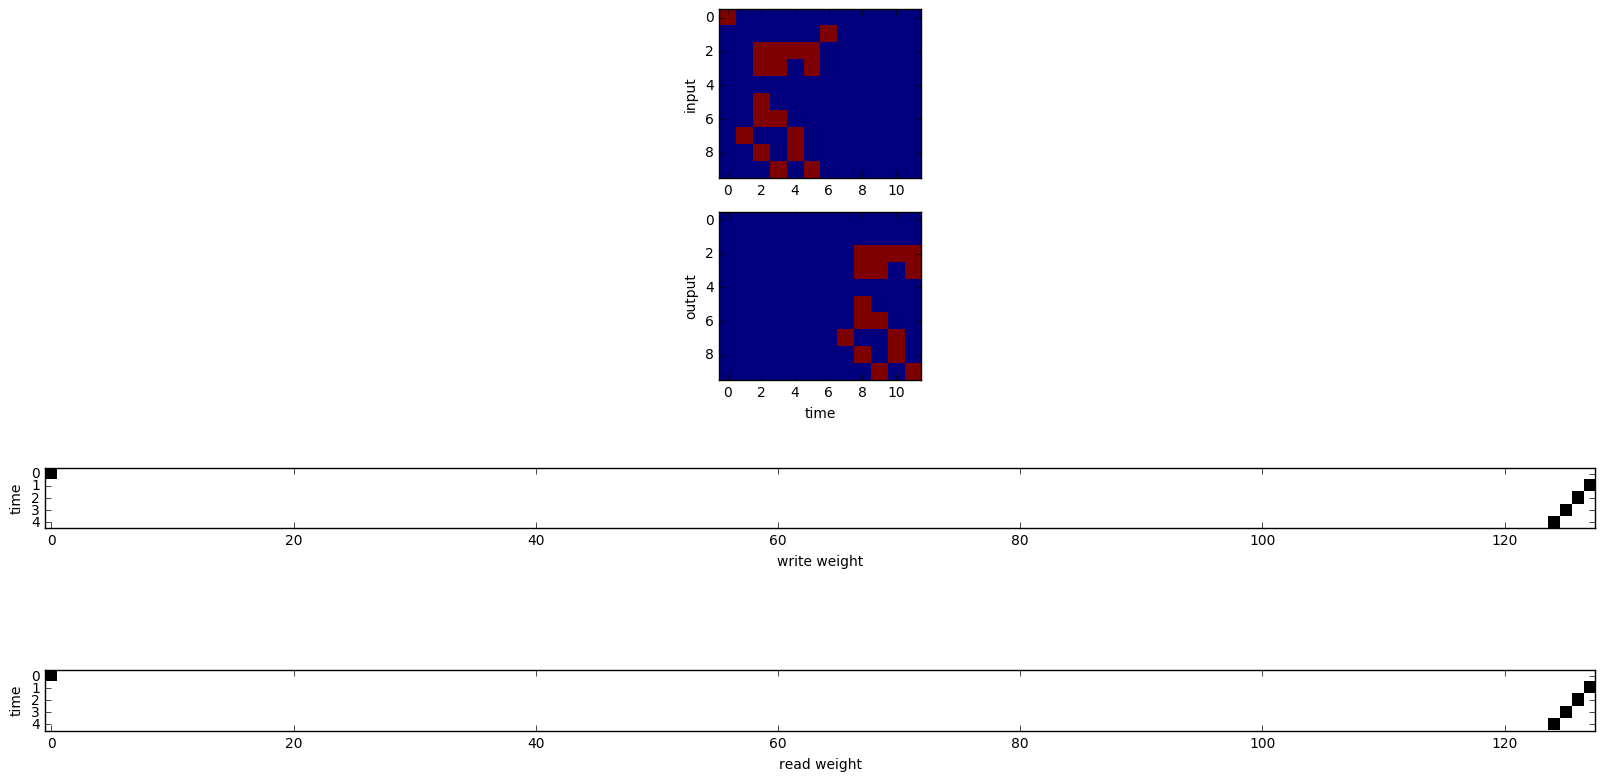

In [16]:
plot(ntm, 5, sess)

Loss : 0.139629


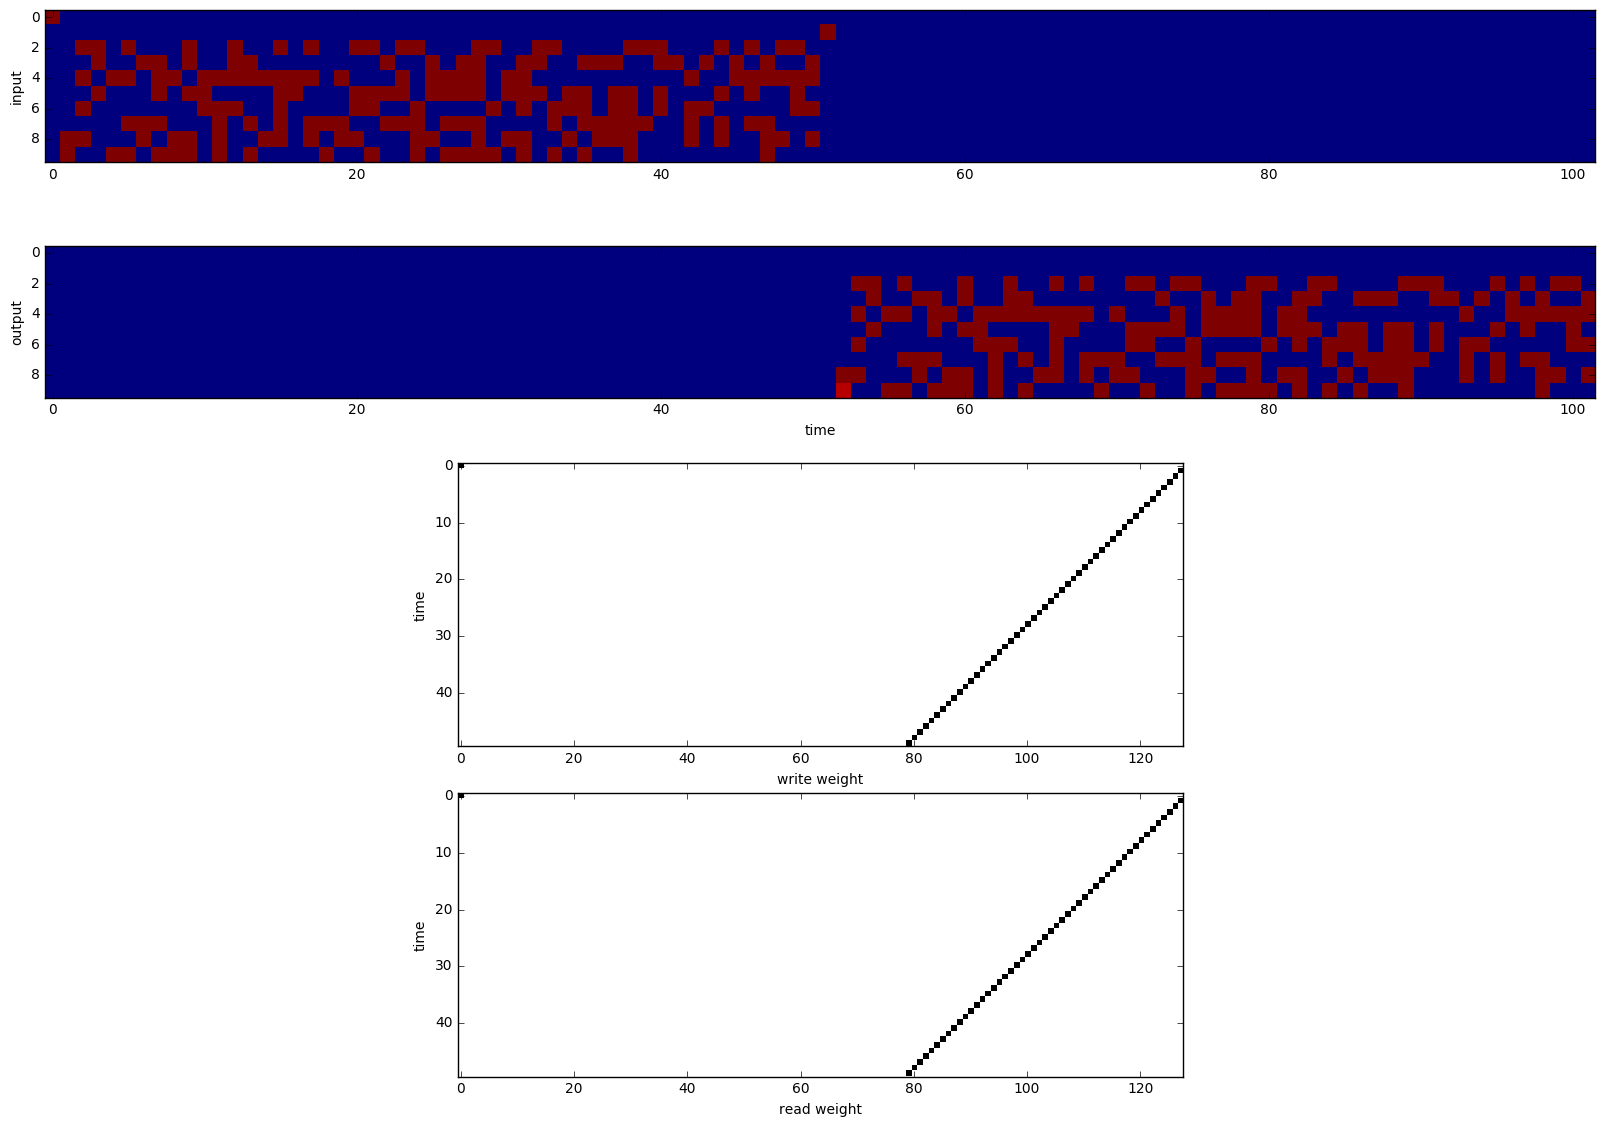

In [17]:
plot(ntm, 50, sess)